In [1]:
"""
This is the behavior cloning project code I used for training. Though, to be,
fair, in the end performance depends mostly on the data. Also, this is just a 
copy paste from IPYTHON code

"""

import os
import argparse
import json

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import load_model
from keras.models import model_from_json
from keras.layers.normalization import BatchNormalization

import numpy as np

import cv2
import csv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from pandas import ewma

from keras.utils import np_utils
from math import ceil
from math import pi

Using TensorFlow backend.


In [2]:
"""
I joined datasets using both UNIX and WINDOWS conventions, so this is needed
"""

dataset = "com"
dataset_val = "validation"
separator = "/"
separator2 = "\\"

In [3]:
"""
This function takes the dataset as argument and returns the driving log
"""

def getDrivingLog(datasetpath):
    with open('datasets/' + datasetpath + '/driving_log.csv','r') as f:
        datareader = csv.reader(f,delimiter=',')
        driving_log = []
        cnt = 0
        for row in datareader:
            if cnt > 0:
                driving_log.append(row)
            cnt = cnt + 1
    return driving_log

In [4]:
driving_log = getDrivingLog(dataset)
driving_log_val = getDrivingLog(dataset_val)

In [5]:
# Recover image shape
img_path     = 'datasets/' + dataset + '/IMG/' + driving_log[0][0].split(separator)[-1].split(separator2)[-1]
image_center = (mpimg.imread(img_path))[60:140,:,:]
image_shape  = image_center.shape

(80, 320, 3)


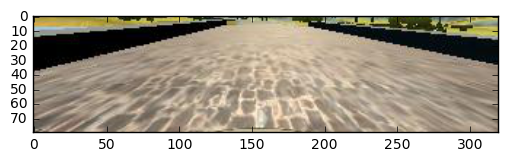

In [6]:
# and display shape
print(image_shape)

# and image
plt.imshow(image_center[0:80,:], cmap = 'gray') 
plt.show()

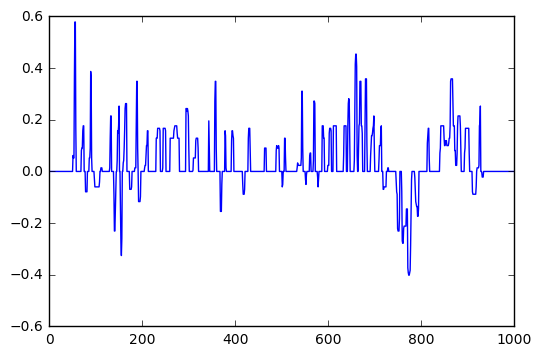

In [7]:
# Display section af angle data
angles = [driving_log[j][3] for j in range(len(driving_log)) ] 
plt.plot(angles[0:1000])
plt.show()

In [8]:
def normalize_channel(image_data):
    x_min = np.min(image_data)
    x_max = np.max(image_data)
    # Non extreme values are useful to avoid saturation for some act funcs
    a     = -0.5
    b     =  0.5
    return a + np.divide( (image_data - x_min ) * ( b - a), x_max - x_min) 

def preprocess_image(img):
    return normalize_channel(img) 

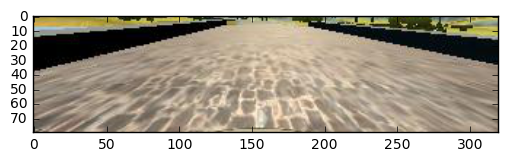

In [9]:
# Show original
plt.imshow(image_center) 
plt.show()

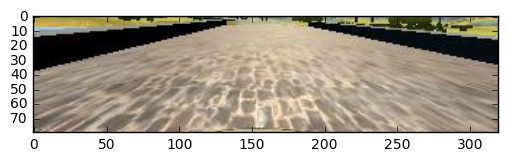

In [10]:
# Show after processing
plt.imshow(0.5 + preprocess_image(image_center)) 
plt.show()

In [11]:
scale_factor = 4;
batch_size = 500;
elements = 6
angle_factor = 0.75

In [12]:
def randomGenerator(datasetpath, drivinglog, forever=1):
    
    total_ticks = 2 * ceil(len(drivinglog) / batch_size)
    go_flag = 1
    while go_flag:
        go_flag = forever
        for i in range(total_ticks):
            
            # Create a random index.
            idx = np.random.choice(len(drivinglog),
                                   size=batch_size,
                                   replace=False)

            y_train   = np.zeros(  elements * (batch_size))
            x_train   = np.zeros(( elements * (batch_size), 
                                  ceil(image_shape[0]/scale_factor), 
                                  image_shape[1]/scale_factor, 
                                  3 ))
            ccidx = 0
            for j in idx:
                center_path = 'datasets/' + datasetpath +'/IMG/' + drivinglog[j][0].split(separator)[-1].split(separator2)[-1]
                left_path   = 'datasets/' + datasetpath +'/IMG/' + drivinglog[j][1].split(separator)[-1].split(separator2)[-1]
                right_path  = 'datasets/' + datasetpath +'/IMG/' + drivinglog[j][2].split(separator)[-1].split(separator2)[-1]
                # Get offset angles for sides
                center_ang  = float(driving_log[j][3])
                flipped_ang = -center_ang
                left_ang    = center_ang + abs(center_ang * angle_factor) + 5 * pi / 180.0
                right_ang   = center_ang - abs(center_ang * angle_factor) - 5 * pi / 180.0
                # Read images, this is kind of our randomization-ish
                image_center = (mpimg.imread(center_path))[60:140,:,:]
                
                image_flip   = (cv2.flip(image_center, 1))
                image_left   = (mpimg.imread(left_path))[60:140,:,:]
                image_right  = (mpimg.imread(right_path))[60:140,:,:]
                image_left_flip  = (cv2.flip(image_left, 1))
                image_right_flip = (cv2.flip(image_right, 1))
                # Resize them
                image_center = cv2.resize(image_center, (0,0), fx=1/scale_factor, fy=1/scale_factor )
                image_flip   = cv2.resize(image_flip,   (0,0), fx=1/scale_factor, fy=1/scale_factor ) 
                image_left   = cv2.resize(image_left,   (0,0), fx=1/scale_factor, fy=1/scale_factor )
                image_right  = cv2.resize(image_right,  (0,0), fx=1/scale_factor, fy=1/scale_factor )
                image_left_flip   = cv2.resize(image_left_flip,   (0,0), fx=1/scale_factor, fy=1/scale_factor )
                image_right_flip  = cv2.resize(image_right_flip,  (0,0), fx=1/scale_factor, fy=1/scale_factor )
                # Preprocess
                image_center = preprocess_image(image_center)
                image_flip   = preprocess_image(image_flip)
                image_left   = preprocess_image(image_left)
                image_right  = preprocess_image(image_right)
                image_left_flip   = preprocess_image(image_left_flip)
                image_right_flip  = preprocess_image(image_right_flip)
                # pass to x_train
                x_train[ccidx,     :, :, :] = image_center[:,:,:]
                x_train[ccidx + 1, :, :, :] = image_flip[:,:,:]
                x_train[ccidx + 2, :, :, :] = image_left[:,:,:]
                x_train[ccidx + 3, :, :, :] = image_right[:,:,:]
                x_train[ccidx + 4, :, :, :] = image_left_flip[:,:,:]
                x_train[ccidx + 5, :, :, :] = image_right_flip[:,:,:]
                # append to our list of Y
                y_train[ccidx    ] = center_ang
                y_train[ccidx + 1] = flipped_ang
                y_train[ccidx + 2] = left_ang
                y_train[ccidx + 3] = right_ang
                y_train[ccidx + 4] = -left_ang
                y_train[ccidx + 5] = -right_ang
                
                ccidx = ccidx + elements
            yield x_train, y_train

In [13]:
def simpleGenerator(datasetpath, drivinglog):
    
    total_ticks = ceil(len(drivinglog) / batch_size)
    
    for i in range(total_ticks):

        y_train   = np.zeros(  elements * (batch_size))
        x_train   = np.zeros( ( elements * (batch_size), 
                                ceil(image_shape[0]/scale_factor), 
                                image_shape[1]/scale_factor, 
                                3 ))
        
        idx = [x for x in range(i * batch_size, min( len(drivinglog), (i + 1) * batch_size))]
        ccidx = 0
        for j in idx:
            center_path = 'datasets/' + datasetpath +'/IMG/' + drivinglog[j][0].split(separator)[-1].split(separator2)[-1]
            left_path   = 'datasets/' + datasetpath +'/IMG/' + drivinglog[j][1].split(separator)[-1].split(separator2)[-1]
            right_path  = 'datasets/' + datasetpath +'/IMG/' + drivinglog[j][2].split(separator)[-1].split(separator2)[-1]
            # Get offset angles for sides
            center_ang  = float(driving_log[j][3])
            flipped_ang = -center_ang
            left_ang    = center_ang + abs(center_ang * angle_factor) + 5 * pi / 180.0
            right_ang   = center_ang - abs(center_ang * angle_factor) - 5 * pi / 180.0
            # Read images, this is kind of our randomization-ish
            image_center = (mpimg.imread(center_path))[60:140,:,:]

            image_flip   = (cv2.flip(image_center, 1))
            image_left   = (mpimg.imread(left_path))[60:140,:,:]
            image_right  = (mpimg.imread(right_path))[60:140,:,:]
            image_left_flip  = (cv2.flip(image_left, 1))
            image_right_flip = (cv2.flip(image_right, 1))
            # Resize them
            image_center = cv2.resize(image_center, (0,0), fx=1/scale_factor, fy=1/scale_factor )
            image_flip   = cv2.resize(image_flip,   (0,0), fx=1/scale_factor, fy=1/scale_factor ) 
            image_left   = cv2.resize(image_left,   (0,0), fx=1/scale_factor, fy=1/scale_factor )
            image_right  = cv2.resize(image_right,  (0,0), fx=1/scale_factor, fy=1/scale_factor )
            image_left_flip   = cv2.resize(image_left_flip,   (0,0), fx=1/scale_factor, fy=1/scale_factor )
            image_right_flip  = cv2.resize(image_right_flip,  (0,0), fx=1/scale_factor, fy=1/scale_factor )
            # Preprocess
            image_center = preprocess_image(image_center)
            image_flip   = preprocess_image(image_flip)
            image_left   = preprocess_image(image_left)
            image_right  = preprocess_image(image_right)
            image_left_flip   = preprocess_image(image_left_flip)
            image_right_flip  = preprocess_image(image_right_flip)
            # pass to x_train
            x_train[ccidx,     :, :, :] = image_center[:,:,:]
            x_train[ccidx + 1, :, :, :] = image_flip[:,:,:]
            x_train[ccidx + 2, :, :, :] = image_left[:,:,:]
            x_train[ccidx + 3, :, :, :] = image_right[:,:,:]
            x_train[ccidx + 4, :, :, :] = image_left_flip[:,:,:]
            x_train[ccidx + 5, :, :, :] = image_right_flip[:,:,:]
            # append to our list of Y
            y_train[ccidx    ] = center_ang
            y_train[ccidx + 1] = flipped_ang
            y_train[ccidx + 2] = left_ang
            y_train[ccidx + 3] = right_ang
            y_train[ccidx + 4] = -left_ang
            y_train[ccidx + 5] = -right_ang

            ccidx = ccidx + elements
            
        yield x_train, y_train

In [14]:
x_test, y_test = next(randomGenerator(dataset, driving_log, 0))

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [15]:
x_val, y_val = next(simpleGenerator(dataset_val, driving_log_val))

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(3000, 20, 80, 3)
[-0.00996884  0.62834984 -0.1072293   0.1072293   0.06045914]


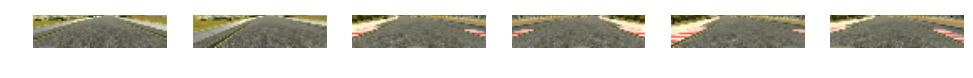

In [17]:
# Show some images from sets

print(x_test.shape)
print(y_test[100:105])

fig   = plt.figure(figsize=(12,6))

fig.add_subplot(1,6,1)
plt.imshow((0.5 + x_test[100][:,:,:]), cmap='gray')
plt.axis('off')

fig.add_subplot(1,6,2)
plt.imshow((0.5 + x_test[101][:,:,:]), cmap='gray')
plt.axis('off')

fig.add_subplot(1,6,3)
plt.imshow((0.5 + x_test[102][:,:,:]), cmap='gray')
plt.axis('off')

fig.add_subplot(1,6,4)
plt.imshow((0.5 + x_test[103][:,:,:]), cmap='gray')
plt.axis('off')

fig.add_subplot(1,6,5)
plt.imshow((0.5 + x_test[104][:,:,:]), cmap='gray')
plt.axis('off')

fig.add_subplot(1,6,6)
plt.imshow((0.5 + x_test[105][:,:,:]), cmap='gray')
plt.axis('off')

plt.show()

In [18]:
model = Sequential()

input_shape = (ceil(image_shape[0]/scale_factor), image_shape[1]/scale_factor, 3)

model.add(Convolution2D(48, 3, 3, subsample=(1, 1), border_mode="same", input_shape=input_shape, init = "he_normal"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('elu'))

model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same", init = "he_normal"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('elu'))

model.add(Convolution2D(80, 3, 3, subsample=(1, 1), border_mode="same", init = "he_normal"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('elu'))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(512, init = "he_normal"))
model.add(Activation('elu'))

model.add(Dense(256, init = "he_normal"))
model.add(Activation('elu'))

model.add(Dense(128, init = "he_normal"))
model.add(Activation('elu'))

model.add(Dense(64, init = "he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.2))

model.add(Dense(16, init = "he_normal"))
model.add(Activation('elu'))

model.add(Dense(1))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 20, 80.0, 48)  1344        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 10, 40.0, 48)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 10, 40.0, 48)  0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 10, 40.0, 64)  27712       activation_1[0][0]               
___________________________________________________________________________________________

In [19]:
my_adam = Adam(lr=0.00001)
model.compile(optimizer=my_adam, loss="mse")

In [20]:
"""
Test for a single image
"""
image_center = x_test[0]
transformed_image_array = image_center[None, :, :, :]
float(model.predict(transformed_image_array, batch_size=1))

0.012907151132822037

In [21]:
# Load saved model to retrain
model = load_model('modelSingle.h5')

In [15]:
model.fit_generator(randomGenerator(dataset, driving_log), samples_per_epoch = 2 * elements * batch_size * ceil(len(driving_log) / batch_size), nb_epoch=1, verbose=1, show_accuracy=True, callbacks=[], validation_data=simpleGenerator(dataset_val, driving_log_val), nb_val_samples=batch_size * elements, class_weight=None, nb_worker=1)

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py:885: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '
C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Epoch 1/1
27000/30000 [==========================>...] - ETA: 11s - loss: 0.0346

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


30000/30000 [==============================] - 124s - loss: 0.0341 - val_loss: 0.0248


In [16]:
# Save for later
model.save('modelSingle.h5')